Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part two of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [5]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

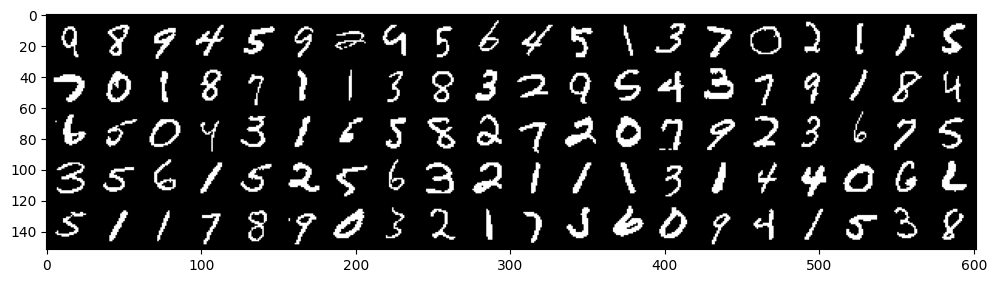

In [6]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points if you do something "interesting", by which I specifically mean "more performant". In particular we are looking for architectures which
    - (a) perform better than a feed-forward network, while 
    - (b) having fewer parameters.

In particular: for full *bonus* credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions. 


In [7]:
class Encoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define any networks (which extend 'nn.Module') here:
        # Anything that has parameters should be defined here!
        
        # e.g., a linear layer could be defined as 
        # self.fc = nn.Linear(784, D_latent)
        #
        # Later on in the `.forward` method, you then can call this.
        #
        # Some ``useful'' layers include:
        #
        # nn.Linear, nn.ReLU, nn.Conv2d, nn.Sequential, nn.Softplus, ...

        # Define a simple feed-forward network to reduce the input down to the latent representation.
        # Flatten the input (784 = 28 * 28), apply a hidden layer, and finally output mu and logvar.
        
        self.fc1 = nn.Linear(784, 400)  # Hidden layer
        self.fc_mu = nn.Linear(400, D_latent)  # Latent mean
        self.fc_logvar = nn.Linear(400, D_latent)  # Latent log-variance

    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        # YOUR CODE HERE
        # Flatten the input image
        X = X.view(X.size(0), -1)  # (batch_size, 784)
        
        # Feed through the first hidden layer
        h = torch.nn.functional.relu(self.fc1(X))
        
        # Obtain mu and logvar for latent distribution
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        # Ensure correct shape
        assert mu.shape == (X.shape[0], self.D_latent)
        assert logvar.shape == mu.shape
        
        # Create a normal distribution with given mean (mu) and standard deviation (sigma)
        sigma = torch.exp(0.5 * logvar)  # Standard deviation = exp(0.5 * logvar)
        return dist.Normal(mu, sigma)


In [10]:
class Decoder(nn.Module):
    def __init__(self, D_latent):
        """
        Initialize the Decoder `nn.Module`.

        This will operate on inputs of shape (batch_size, D_latent).

        INPUTS:
        D_latent: size of latent space (integer)
        """
        super(Decoder, self).__init__()
        self.D_latent = D_latent

        # Define the layers of the Decoder.
        self.fc1 = nn.Linear(D_latent, 400)  # First fully connected layer
        self.fc2 = nn.Linear(400, 784)  # Output fully connected layer (784 = 28 * 28)

    def forward(self, Z):
        """
        Return a distribution p(x | z)

        INPUT:
        Z   : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)

        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """
        # Apply the first layer with ReLU activation
        h = torch.nn.functional.relu(self.fc1(Z))

        # Apply the second layer with sigmoid activation to constrain output between 0 and 1
        X_hat = torch.sigmoid(self.fc2(h))

        # Reshape X_hat to match the original image shape: (batch_size, 1, 28, 28)
        X_hat = X_hat.view(-1, 1, 28, 28)

        # Return a Bernoulli distribution over the output (since MNIST pixels are either 0 or 1)
        return dist.Bernoulli(probs=X_hat)


# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a **single-sample** Monte Carlo estimate of

$$ELBO(x_i) = \mathbb{E}_{q(z_i | x_i)}\left[ \log \left [ \frac{p(z_i)p(x_i | z_i)}{q(z_i | x_i)} \right ] \right ]$$

where $q(z_i | x_i)$ and $p(x_i | z_i)$ are returned by the `Encoder` and `Decoder` classes you defined above.

Note that I have written this as the **per-datapoint** ELBO. 

For ease of inspecting your code, please have your `ELBO_VAE` function below return a Torch vector, i.e. a tensor of shape `(batch_size,)`, containing the per-datapoint ELBO values.


In [11]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28)
    
    
    OUTPUT: a torch.FloatTensor of shape = (batch_size, ) containing the estimate 
            of the per-datapoint ELBO for every data point in the batch.
    
    """

    # Flatten the input images (batch_size, 1, 28, 28) -> (batch_size, 784)
    X_flattened = X.view(X.shape[0], -1)

    # Get the mean (mu) and log variance (logvar) from the encoder
    q_z_x = enc(X_flattened)  # q_z_x is a torch distribution (e.g., Normal(mu, sigma))
    z_sample = q_z_x.rsample()  # Sample z from the distribution (reparameterization trick)

    # Pass sampled z to the decoder to reconstruct X
    p_x_z = dec(z_sample)  # p_x_z is a torch distribution (e.g., Bernoulli)

    # Compute the log-likelihood term: log(p(x|z))
    log_px_given_z = p_x_z.log_prob(X).sum(dim=[1, 2, 3])  # Sum over all the dimensions

    # Compute the KL divergence term: KL(q(z|x) || p(z))
    # Prior p(z) ~ N(0, I), which is standard normal
    p_z = dist.Normal(torch.zeros_like(z_sample), torch.ones_like(z_sample))
    kl_divergence = dist.kl_divergence(q_z_x, p_z).sum(dim=1)  # Sum over latent dimensions

    # ELBO = log(p(x|z)) - KL(q(z|x) || p(z))
    elbo = log_px_given_z - kl_divergence

    return elbo


# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [12]:
# Try modifying this and seeing how it affects performance!
D_latent = 2

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [13]:
def run_training(N_epochs, enc, dec):
    """ Outer loop for training the VAE 
    
        Calls your `ELBO_VAE` function!
    """
    for epoch in range(N_epochs):
        train_loss = 0.0
        for (X, _) in train_loader:
            opt_vae.zero_grad()
            
            # Call you ELBO implementation
            elbos = ELBO_VAE(enc, dec, X)
            
            # Please don't break the following assertion (check your return shape!)
            batch_size = X.shape[0]
            assert elbos.shape == (batch_size,)
            
            # The loss is the sum of the negative per-datapoint ELBO
            loss = -elbos.sum()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
        print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [14]:
# ignore this cell (placeholder)


In [15]:
N_epochs = 30 # Note that you may want to run more epochs!
run_training(N_epochs, enc, dec)

Epoch 0, train loss = 18532.8616
Epoch 1, train loss = 16372.7329
Epoch 2, train loss = 16008.1728
Epoch 3, train loss = 15773.3053
Epoch 4, train loss = 15599.6310
Epoch 5, train loss = 15452.1187
Epoch 6, train loss = 15319.5923
Epoch 7, train loss = 15202.2591
Epoch 8, train loss = 15105.0068
Epoch 9, train loss = 15021.1198
Epoch 10, train loss = 14943.9679
Epoch 11, train loss = 14881.9735
Epoch 12, train loss = 14819.1969
Epoch 13, train loss = 14769.0367
Epoch 14, train loss = 14722.2671
Epoch 15, train loss = 14673.9605
Epoch 16, train loss = 14636.9696
Epoch 17, train loss = 14594.7870
Epoch 18, train loss = 14558.9032
Epoch 19, train loss = 14522.7774
Epoch 20, train loss = 14493.2454
Epoch 21, train loss = 14456.4087
Epoch 22, train loss = 14430.9841
Epoch 23, train loss = 14404.3419
Epoch 24, train loss = 14373.4773
Epoch 25, train loss = 14353.4450
Epoch 26, train loss = 14327.9440
Epoch 27, train loss = 14306.2706
Epoch 28, train loss = 14280.2299
Epoch 29, train loss = 1

## Do reconstructions look like the input?

Reconstruction accuracy: 0.89


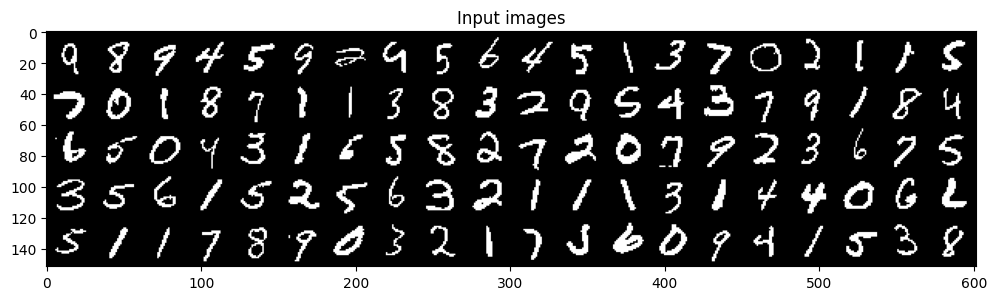

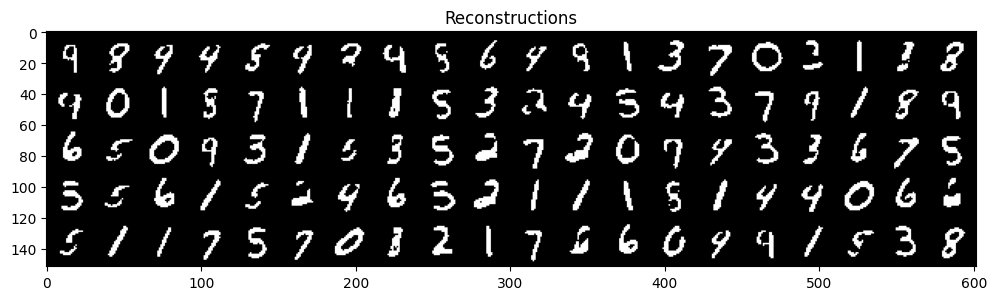

In [16]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
    
print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

## Do randomly generated samples look coherent?

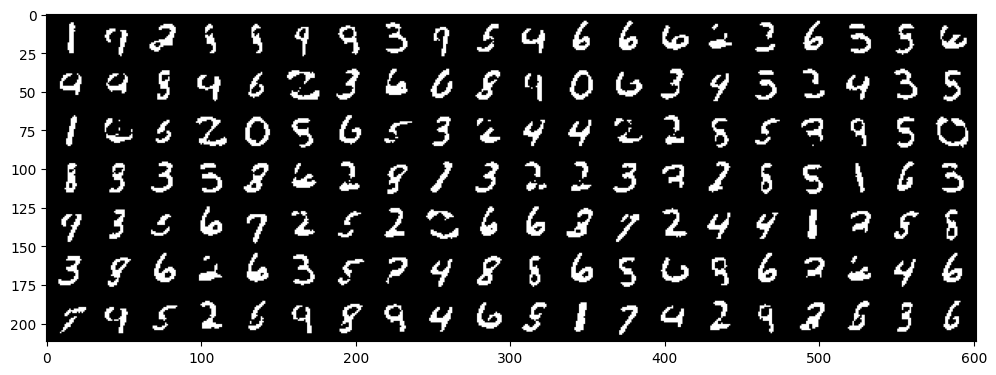

In [17]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

C:\Users\weinana\OneDrive - University College London\UCL DSML\pythonProject\.venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


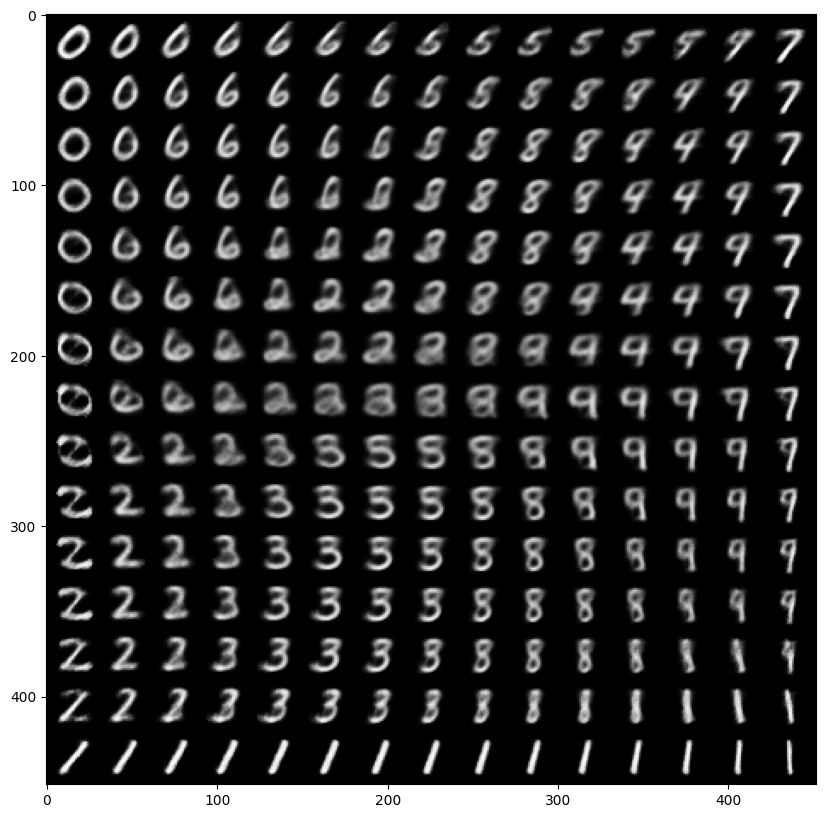

In [18]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [65]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading
